In [1]:
import numpy as np
import pandas as pd
from sodapy import Socrata
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Download Data

# Code Snippet taken from
# https://dev.socrata.com/foundry/www.datos.gov.co/gt2j-8ykr
#
# Useful documentation
# https://dev.socrata.com/docs/filtering.html

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("www.datos.gov.co", None)

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
q1 = "departamento=15"
results = client.get("gt2j-8ykr", where=q1, limit=1000000)
download_date = datetime.now() # Record date & time of data donwnload


# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

print("Data download date & time \n", download_date,"\n"*2)
results_df.info()

Data download date & time 
 2021-06-10 15:41:20.253867 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73168 entries, 0 to 73167
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   fecha_reporte_web      73168 non-null  object
 1   id_de_caso             73168 non-null  object
 2   fecha_de_notificaci_n  73168 non-null  object
 3   departamento           73168 non-null  object
 4   departamento_nom       73168 non-null  object
 5   ciudad_municipio       73168 non-null  object
 6   ciudad_municipio_nom   73168 non-null  object
 7   edad                   73168 non-null  object
 8   unidad_medida          73168 non-null  object
 9   sexo                   73168 non-null  object
 10  fuente_tipo_contagio   72985 non-null  object
 11  ubicacion              73168 non-null  object
 12  estado                 73168 non-null  object
 13  recuperado             73168 non-null  object
 14  fecha_inicio

In [3]:
# Load Data
df = results_df.copy()
#del results_df

# Drop columns
drop_columns = ["departamento", 
                "departamento_nom", 
                "ciudad_municipio",
                "unidad_medida", 
                "per_etn_", 
                "nom_grupo_",
                "pais_viajo_1_cod",
                "pais_viajo_1_nom",
                "edad",
                "sexo",
                "fuente_tipo_contagio",
                "ubicacion",
                "estado",
                "tipo_recuperacion"
               ]
df = df.drop(columns=drop_columns)

# Transform dates to datetime objects using the propper format
dates = ["fecha_reporte_web", 
         "fecha_de_notificaci_n", 
         "fecha_inicio_sintomas", 
         "fecha_muerte", 
         "fecha_diagnostico", 
         "fecha_recuperado"
        ]
formated_dates = ["f_reporte_web", 
                  "f_notificacion", 
                  "f_ini_sintomas", 
                  "f_muerte", 
                  "f_diagnostico", 
                  "f_recuperacion"
                 ]
print("\n*** Formating Dates")
for i in range(len(dates)):
    print(dates[i], "\t\t--->", formated_dates[i])
    df[formated_dates[i]] = pd.to_datetime( df[dates[i]], format='%d/%m/%Y %H:%M:%S' )

df = df.drop(columns=dates)


# "Estado" column has NaN values for some cases with a valid pass-away date
# Correct those NaN with "Fallecido"
number_of_nans = np.sum(df["recuperado"].isna())
print("\n*** Number of Nans in 'recuperado' column = ", number_of_nans)
if number_of_nans != 0:
    row_indexer = ~df["f_muerte"].isna() # rows with valid pass-away dates
    df.loc[ (row_indexer) , "recuperado" ] = "Fallecido" # Fix value for "Recuperado" column
    print("-->Correction of 'fallecido' value in 'recuperado' column for ", np.sum(row_indexer), "rows")
else:
    print("--> No Correction required")

print("\n")
print(df.info())

print("\n*** Most recent reported dates\n", df.loc[:,formated_dates].max())
df = df.drop(columns=["f_reporte_web","f_notificacion"])


*** Formating Dates
fecha_reporte_web 		---> f_reporte_web
fecha_de_notificaci_n 		---> f_notificacion
fecha_inicio_sintomas 		---> f_ini_sintomas
fecha_muerte 		---> f_muerte
fecha_diagnostico 		---> f_diagnostico
fecha_recuperado 		---> f_recuperacion

*** Number of Nans in 'recuperado' column =  0
--> No Correction required


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73168 entries, 0 to 73167
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id_de_caso            73168 non-null  object        
 1   ciudad_municipio_nom  73168 non-null  object        
 2   recuperado            73168 non-null  object        
 3   f_reporte_web         73168 non-null  datetime64[ns]
 4   f_notificacion        73168 non-null  datetime64[ns]
 5   f_ini_sintomas        72602 non-null  datetime64[ns]
 6   f_muerte              2018 non-null   datetime64[ns]
 7   f_diagnostico         73160 non-n

In [4]:
# Print Observations with NaN in "Recuperado"
df[df["recuperado"].isna()]

,id_de_caso,ciudad_municipio_nom,recuperado,f_ini_sintomas,f_muerte,f_diagnostico,f_recuperacion


## Resumen de casos por municipio

In [5]:
resumen = df.pivot_table(index="ciudad_municipio_nom", columns="recuperado", values="id_de_caso", aggfunc=np.count_nonzero).fillna(0)
resumen = resumen.sort_values("Activo", ascending=False)
#resumen["T"] = resumen.sum(axis=1) # Compute total observations to compare with number of "ID de caso"
resumen.astype(int).head(20)

# count "ID de caso" to compare with same calculation from the "Recuperado Column"
#df.groupby("Nombre municipio")["ID de caso"].agg(np.count_nonzero).sort_values(ascending=False)

recuperado,Activo,Fallecido,N/A,Recuperado
ciudad_municipio_nom,,,,
TUNJA,876,269,54,19260
DUITAMA,437,312,43,12197
SOGAMOSO,357,360,46,12396
CHIQUINQUIRA,328,115,21,3846
VILLA DE LEYVA,59,31,1,629
PUERTO BOYACA,43,79,12,2537
PAIPA,42,56,11,2103
SAMACA,40,26,4,1132
GARAGOA,29,34,1,851


In [6]:
# Generate dummi variables to easily create the time series
d_recuperado = pd.get_dummies(df["recuperado"], prefix='d')
d_df = pd.concat([df, d_recuperado], axis=1) 
d_df = d_df.drop(columns=["recuperado","d_Activo"])
d_df.head()

,id_de_caso,ciudad_municipio_nom,f_ini_sintomas,f_muerte,f_diagnostico,f_recuperacion,d_Fallecido,d_N/A,d_Recuperado
0,445,SANTANA,2020-03-13,NaT,2020-03-25,2020-04-06,0,0,1
1,489,TUNJA,2020-03-22,NaT,2020-03-26,2020-04-06,0,0,1
2,690,OICATA,2020-03-25,NaT,2020-03-29,2020-04-11,0,0,1
3,703,SANTANA,2020-03-18,NaT,2020-03-30,2020-04-13,0,0,1
4,864,TUNJA,2020-03-22,2020-04-04,2020-03-31,NaT,1,0,0


In [7]:
# Create time series for active, recovered, passaway
# Each time series requires to be done independently

# Create acumulate time series using pivot tables
new_cases = d_df.pivot_table(index="f_ini_sintomas", 
                                  values="id_de_caso", 
                                  columns="ciudad_municipio_nom", 
                                  aggfunc=np.count_nonzero)
cum_new_cases = new_cases.sort_index(ascending=True).cumsum() 

new_rec = d_df.pivot_table(index="f_recuperacion",
                                values="d_Recuperado",
                                columns="ciudad_municipio_nom",
                                aggfunc=np.count_nonzero)
cum_rec = new_rec.sort_index(ascending=True).cumsum()

new_pa = d_df.pivot_table(index="f_muerte",
                              values="d_Fallecido",
                              columns="ciudad_municipio_nom",
                              aggfunc=np.count_nonzero)
cum_pa = new_pa.sort_index(ascending=True).cumsum()

In [8]:
# Resample all 3 time series in the same index so they can be summed
d_min = min([d_df.f_ini_sintomas.min(), d_df.f_recuperacion.min()])
d_max = max([d_df.f_ini_sintomas.max(), d_df.f_recuperacion.max()])
t_index = pd.date_range(start=d_min, end=d_max, freq='D')
print(d_min, d_max, sep="\n")

# Use pad() to fill values to the front and fillna(0) to fill NaN with 0
r_cum_new_cases = cum_new_cases.reindex(t_index).pad().fillna(0)
r_cum_rec = cum_rec.reindex(t_index).pad().fillna(0)
r_cum_pa = cum_pa.reindex(t_index).pad().fillna(0)

# Compute active cases: cumulative new cases - cummulative recovered - cummulative p.a.
active_cases = r_cum_new_cases - r_cum_rec - r_cum_pa

2020-03-13 00:00:00
2021-06-09 00:00:00


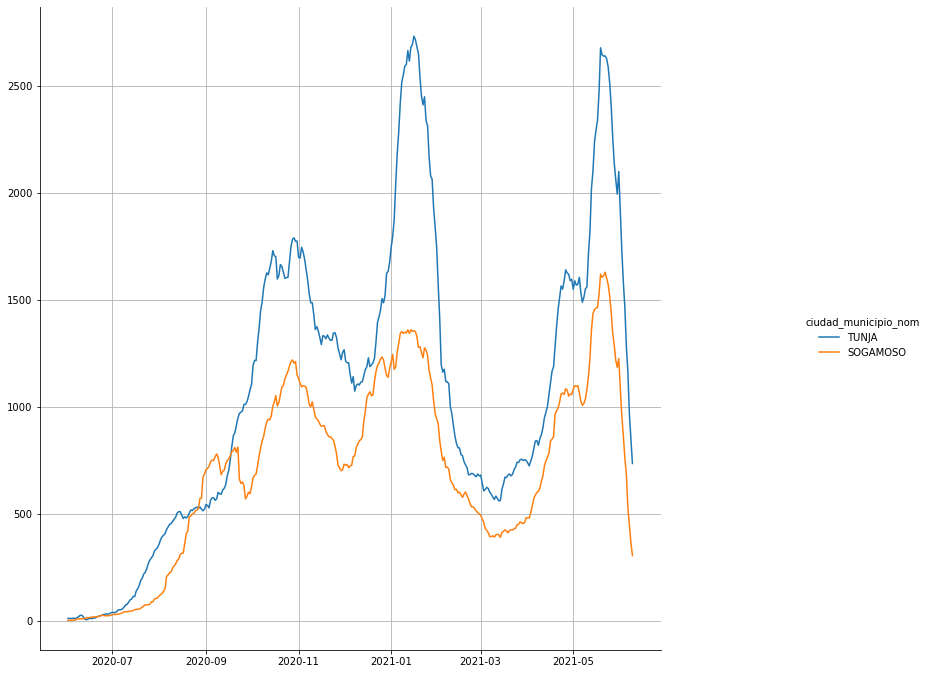

In [9]:
towns = ["TUNJA", "SOGAMOSO"]
g = sns.relplot(data=active_cases.loc[active_cases.index > "2020-06-01",towns],
           kind='line',
           dashes=False)
plt.grid()
g.fig.set_size_inches(14,10)

# Provincia Marquez

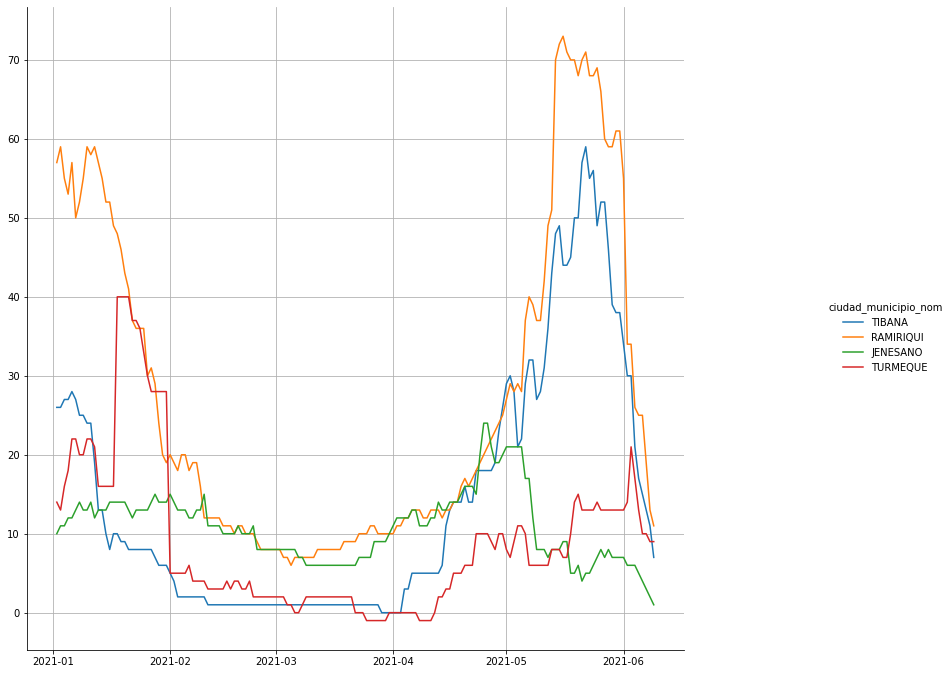

In [10]:
towns = ["TIBANA", "RAMIRIQUI", "JENESANO","TURMEQUE"]
g = sns.relplot(data=active_cases.loc[active_cases.index > "2021-01-01",towns],
           kind='line',
           dashes=False)
g.fig.set_size_inches(14,10)
plt.grid()